# Exploring the Pitchfork dataset

In this tutorial we are conducting a quick exploratory analysis of the pitchfork dataset available on [Kaggle](https://www.kaggle.com/nolanbconaway/pitchfork-data). [Pitchfork](https://pitchfork.com/) is an specialized music news and reviews website. The dataset is composed of reviews of many albums spanning from 2001 to 2017. We were interested in exploring the usage of [spaCy](http://spacy.io) one of the most popular NLP libraries out there for all the aspects of the NLP pipeline.



In [1]:
# Load the necessary libraries for the analysis
import numpy as np 
import pandas as pd 
import sqlite3 as lite
from pandas.io.sql import read_sql

We will be working with spaCy 2.1.4, so this means that unlike V1 of spacy the multithread feature that helped accelerate execution time is no longer available (for a discussion of this change see this [post](https://spacy.io/usage/v2). But fear not as spaCy is compatible with GPU, thus performance shouldn't be an issue. We simply need to install spaCy specifiying the version of cudas we have available in our system, download the models and get up to speed!. So in your computer all you need to do is this:

In [ ]:
!pip install -U spacy[cuda100] #remember to change the version of your cuda library

Once the installation is completed we can verify that the installation was successful by entering the following command.

In [3]:
# We w
import spacy
spacy.require_gpu()

True

If the installation was succesful we should see a 'True' message. In case you receive an error message pertaining 'gpu_ops' not found, you would need to downgrade Thinc from the current version (as of June 2019) 7.0.4 to 7.0.3. This issue is discussed [here](https://github.com/explosion/spaCy/issues/3437). Once we have spacy ready to go we can start by defining a connection to our data dump.

In [4]:
# we define the connection to the database

con = lite.connect('pitchfork.sqlite') # in this case we changed the name of the database to make it easier to identify


The database is composed of seven tables that contain information about the artist, the album reviewed, the date of publication, grade of the review, etc. Since we are interested in the reviews we will focus on the reviews and content tables. We can use pandas and sql lite to 'query' the information and store it as a nice data frame.

In [5]:
# query the information from the database
df = read_sql(""" SELECT a.content , b.* FROM content a LEFT JOIN reviews b """
              """ ON a.reviewid=b.reviewid """,
              con, coerce_float=True, params=None) 

# quickly check content
df.head(3)

,content,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,"“Trip-hop” eventually became a ’90s punchline,...",22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,"Eight years, five albums, and two EPs in, the ...",22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,Minneapolis’ Uranium Club seem to revel in bei...,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017


We are interested in understanding how many observations we have and the average lenght of the reviews.

In [26]:
# We are interested in understanding 
print (f' The dataset has {len(df):,} observations, and the average lenght of a review is {np.mean(df.content.apply(lambda x: len(x))):,.2f}\n' \
       f' characters')
#df[df['reviewid']==22719]

 The dataset has 18,401 observations, and the average lenght of a review is 4,057.50
 characters


# Using spaCy 

We are going to use the spaCy large english model. For an introduction of spaCy and the logic of their model we recommend this [tutorial](https://spacy.io/usage/spacy-101) that covers the basics of the library. The library loads a model in the nlp class, where the model is then retrieved and used for all kinds of different nlp tasks. In our case we will use the standard pipeline that includes a tagger, a parser and a name entity recognition module.

In [28]:
# load the large english model
nlp = spacy.load('en_core_web_lg')

# check the default components
print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fd5056330b8>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fd5046763a8>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fd504676408>)]


In [33]:
! ls


 aclImdb			 'spacy tutorial 1.ipynb'
 aind-dl-linux.yml		  standford
 blog.odt			  Student_Admissions.ipynb
 clustering_and_data_viz.ipynb	  student_data.csv
 database.sqlite.zip		  testing_doc2vec.ipynb
 doc2vec_gensim3_6.ipynb	  testing_doc2vec_tutorial.ipynb
'flair experiments-Copy1.ipynb'   testing_doc2vec_v2.ipynb
 IMDB_In_Keras.ipynb		  testing_word2vec.ipynb
 IMDB_In_Keras_Solutions.ipynb	  train_positive_clean.txt
 pitchfork.sqlite		  tran_negative_clean.txt
 README.md			  undefined_clean.txt
 requirements.txt


The nlp pipeline takes a document, process it according to the specified pipeline and returns a spaCy document. We then can explore the different attributes for each docucment, such as named entities, POS, sentences, etc.
![title](pipeline_spacy.png)
Taken from spaCy webpage


Before we process all the reviews we convert them to a list of documents.

In [45]:
list_reviews= df['content'].tolist()

The `nlp.pipe` method uses thinc under the hood to process each document in the order of the established pipeline. As of v2 of spaCy the model is now implemented as a neural network and as a result the multithread argument no longer gets rid of the infamous GIL (see this [explanation](https://spacy.io/usage/v2-1)). So the best way to use the library is through GPU support. For example processing the pipeline using cpu only takes **2 hours and 27 minutes!**:
![title](slow_nlp.png)



Now if we run the same code using the GPU optimized version (we are running this on a EVGA GeForce GTX 1080 SC 8GB) it only takes 6 minutes a **24x improvement!**.

In [46]:
%%time
list_reviews_processed=list(nlp.pipe(list_reviews, batch_size=256))

CPU times: user 5min 23s, sys: 39.3 s, total: 6min 2s
Wall time: 6min 3s


Since the dataset is a compilation of reviews we can start by having a look at the distribution of adjectives in the dataset. To do this we define a function that returns a list of adjectives or any other POS tagger of interest. We do this so we can further analyze the results by merging it back with our data frame (for example if we wanted to understand the distribution of adjective per year or genre). Since we have a list of documents we need to take that into consideration when extracting information from the documents.

In [37]:
# Start by compiling a list of words by POS tagging. We define a simple function

def return_pos_tags_text (documents, tag = None):
    # define a list to return the result, the list should be of the same length as 
    adjectives_in_review = []

    for document in documents:
        
        adjectives = []
        for i in document:
        # filter for 
          if i.pos_== tag and len(i.text)> 2:
            adjectives.append(i.text)
        
        adjectives_in_review.append(adjectives)
    
    return adjectives_in_review

In [49]:
adjectives_in_review = return_pos_tags_text(list_reviews_processed, tag = "ADJ")

print(f'There are {len(adjectives_in_review):,} list of adjectives in our new list')

There are 18,401 list of adjectives in our new list


Let's plott the top 25 most common adjectives in the dataset 

In [52]:
from collections import Counter 
adjectives = Counter([x for xs in adjectives_in_review for x in set(xs)]) 
adjectives_df = pd.DataFrame(adjectives.most_common(), columns=['adjective','count']) 
adjectives_df.head()

,adjective,count
0,more,10081
1,first,9381
2,new,8790
3,other,8470
4,own,7814


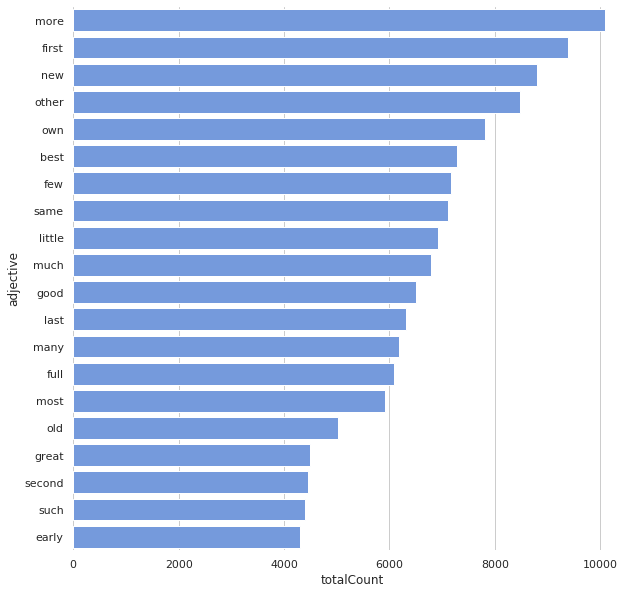

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
sns.plt.xlim(0, None)

ax = sns.barplot(x='count', y='adjective', data=adjectives_df.iloc[0:20], color="cornflowerblue")
ax.set_xlabel('Top 20 most common adjectives in Pitchfork reviews')

sns.despine(left=True, bottom=True)

One of the things we want to explore is the distribution of adjectives most frequently used by good music and bad music. We will see what the median score is, the minumun and plot a histogram.

In [67]:
print(np.median(df['score']),np.min(df['score']))

7.2 0.0


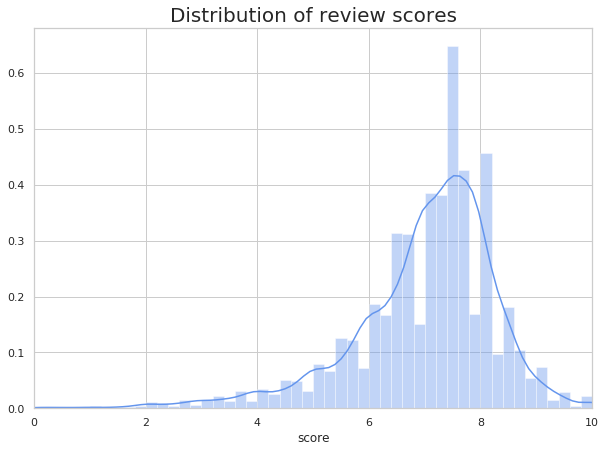

In [82]:
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))
plt.xlim(0, 10)
ax.set_title('Distribution of review scores', fontsize=20)
ax = sns.distplot(df['score'], color="cornflowerblue")

In [99]:
# explore distribution of adjeectives for words below 7 and above 7. We will create to dataframes and plot the top
# 20 most common adjectives for above 7 and below
adjectives_in_review_below=df[['score']].merge()
adjectives_in_review_above
    
len(adjectives_in_review)

TypeError: merge() missing 1 required positional argument: 'right'

In [100]:
adjectives_in_review_below=df[['score']].merge(pd.DataFrame({'adjectives':adjectives_in_review}), 
                                               left_index=True, right_index=True)


In [98]:
adjectives_in_review_below = adjectives_in_review_below[adjectives_in_review_below['score']<=7.0]
print(len(adjectives_in_review_below))

8082


In [ ]:
adjectives_in_review_below

In [ ]:
The list of reviews contains sentences and a bunch of different attributes that can be quite helpful for our analysis.
In this case we will use the POS to identify all the adjectives mentioned in a review.

In [ ]:
for i in list_reviews[0]:
    print (i.text)

In [ ]:
for i,sent in enumerate(list_reviews[0].sents):
    print(sent.ents)